# Dimensionality reduction using Sentinel-2 (PCA & Spectral Embedding)

Authors:

* Jeroen Wannijn

Import dependencies

In [3]:
import io
import matplotlib.pyplot as plt
import numpy as np
import openeo
import openeo.processes as eop
import pickle
import rasterio
import requests
from pathlib import Path
import xarray as xr
import zipfile

# openeo version
openeo.client_version()

'0.40.0'

Creates a output directory if it doesn't exist.

In [4]:
base_path = Path("results")
if not base_path.is_dir():
    base_path.mkdir()

# Introduction
In this notebook, we perform dimensionality reduction on a full data cube of preprocessed Sentinel-2 satellite data. This data can quickly have many dimesions, consisting of many spectral bands, derived indexes and possibly other features, leading to very high-dimensional and heavy datasets. Working directly with such high-dimensional data presents several challenges:


1. Computational Efficiency:
Lower-dimensional data requires less storage and speeds up downstream tasks like classification, clustering, or further processing.

2. Improved Visualization and Interpretation:
By reducing dimensionality, we can visualize complex datasets in 2D or 3D plots, making it easier to understand underlying structures, patterns, or anomalies.

3. Curse of Dimensionality:
As the number of features grows, the data becomes sparse in the feature space, making it harder to find meaningful patterns or clusters. Many machine learning algorithms also suffer performance drops or overfitting in very high dimensions.

## Authentication

We first need to connect to an openEO provider. Most providers require you to register an account, and provide you with a basic amount of processing credits. 
In this notebook we will use the Copernicus Data Scpace Ecosystem as openEO provider.

All the known openEO providers and their services:
https://hub.openeo.org/ 

More info on authentication:
https://open-eo.github.io/openeo-python-client/auth.html

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [5]:
backend_url = "openeo.dataspace.copernicus.eu/"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Create job options for running jobs on CSDE:

This notebook will run two jobs:
- One that select the significant raw bands from the dimensionality reduction model
- One that executes the dimensionality reduction model

Two models are applied, both from scikit-learn, PCA & Spectral Embedding.
They are pre-trained with the same data we use in this notebook, both to reduce all bands to 3 components.

It is recommended to zip your dependencies for scikit-learn, joblib & pickles since they differ vastly over the versions.

More info on scikit-learn PCA analysis:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

More info on scikit-learn Spectral Ebedding analysis:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html




In [ ]:
models_url = "https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/DimReduction/dim_reduction_models.zip"
dependencies_url = (
    "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/dim-reduction-udf-deps-v01.zip"
    )
job_options = {
    'driver-memory': '2G',
    'driver-memoryOverhead': '512m',
    'executor-memory': '2G',
    'executor-memoryOverhead': '512m',
    'python-memory': '4G',  # Spectral Embedding is very memory intensive
    'max-executors': 20,
    "executor-cores": 1,
    "logging-threshold": "info",
    'udf-dependency-archives': [
        f"{models_url}#models",
        f"{dependencies_url}#udf-py-deps"
        ],
}

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A. More information on the collections available can be displayed with `eoconn.list_collections()`.
Use `eoconn.describe_collection("SENTINEL2_L2A")` for example to get the description of a specific collection.

More information on finding and loading data: 
https://open-eo.github.io/openeo-python-client/data_access.html

*Select spatial & temporal extent*

In [7]:
BBOX = {"east": 4878500, "south": 2897000, "west": 4877000, "north": 2898500, 'crs': 'EPSG:3035'} # 1.5x1.5km bbox in Germany
DATE_START = "2021-01-01"
DATE_END = "2022-01-01"

*Select usable observations*:

For this exercise we use the derivatives of the 13 Sentinel-2 bands + NDVI by applying a spatial reduction
- mean 
- median
- max
- min
- q5
- q25
- q75
- q95

This leads to 112 (14x8) dimension to reduce in a dimensionality reduction model.

Load collection

In [8]:
data_cube = eoconn.load_collection(
    "SENTINEL2_L2A",  # or your collection id
    spatial_extent=BBOX,
    temporal_extent=[DATE_START, DATE_END],
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],
    max_cloud_cover=10
)

Mask cloud data

In [9]:
scl = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[DATE_START, DATE_END],
    spatial_extent=BBOX,
    bands=["SCL"],
    max_cloud_cover=10,
)

cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)

data_cube_masked = data_cube.mask(cloud_mask)

Calculate NDVI

In [10]:
data_cube_masked = data_cube_masked.ndvi(red="B04", nir="B08", target_band='NDVI')

Temporally reduce data cube with different statistics

In [11]:
# Get original band labels
band_labels = data_cube_masked.metadata.band_names

# Temporal reduce and prefix new band names
def combined_reducer(t_array):
    """
    Combined EO processes to reduce temporal resolution of an array
    """
    # Define every eo process
    mean = eop.mean(t_array)
    median = eop.median(t_array)
    min = eop.min(t_array)
    max = eop.max(t_array)
    q05 = eop.quantiles(t_array, probabilities=[0.05])
    q25 = eop.quantiles(t_array, probabilities=[0.25])
    q75 = eop.quantiles(t_array, probabilities=[0.75])
    q95 = eop.quantiles(t_array, probabilities=[0.95])
    
    # Stack eo processes into array
    return eop.array_create([mean, median, min, max, q05, q25, q75, q95])

# Now rename bands accordingly:
target_bands = []
for b in band_labels:
    target_bands.extend([
        f"{b}_mean", f"{b}_median", f"{b}_min", f"{b}_max",
        f"{b}_q05", f"{b}_q25", f"{b}_q75", f"{b}_q95"
    ])

# Temporally reduce cube with combined reducer and rename bands accordingly
sentinel_master_cube = data_cube_masked.apply_dimension(
    process=combined_reducer,
    dimension="t",
    target_dimension="bands"
).rename_labels("bands", target=target_bands)

Download to view offline

In [20]:
job = sentinel_master_cube.create_job(
    title="building_S2_stat_cube", out_format="NetCDF", job_options=job_options)
job.start_and_wait()
job.download_result(base_path / "master_S2_cube.nc")

0:00:00 Job 'j-2506301930594e5cbcb06fe38c518db3': send 'start'
0:00:13 Job 'j-2506301930594e5cbcb06fe38c518db3': queued (progress 0%)
0:00:18 Job 'j-2506301930594e5cbcb06fe38c518db3': queued (progress 0%)
0:00:24 Job 'j-2506301930594e5cbcb06fe38c518db3': queued (progress 0%)
0:00:32 Job 'j-2506301930594e5cbcb06fe38c518db3': queued (progress 0%)
0:00:42 Job 'j-2506301930594e5cbcb06fe38c518db3': queued (progress 0%)
0:00:54 Job 'j-2506301930594e5cbcb06fe38c518db3': queued (progress 0%)
0:01:10 Job 'j-2506301930594e5cbcb06fe38c518db3': running (progress N/A)
0:01:29 Job 'j-2506301930594e5cbcb06fe38c518db3': running (progress N/A)
0:01:53 Job 'j-2506301930594e5cbcb06fe38c518db3': running (progress N/A)
0:02:23 Job 'j-2506301930594e5cbcb06fe38c518db3': running (progress N/A)
0:03:01 Job 'j-2506301930594e5cbcb06fe38c518db3': running (progress N/A)
0:03:47 Job 'j-2506301930594e5cbcb06fe38c518db3': running (progress N/A)
0:04:46 Job 'j-2506301930594e5cbcb06fe38c518db3': finished (progress 100%

WindowsPath('results/master_S2_cube.nc')

## Visualise RGB to get a view of the area
Downoad RGB data from Sentinel-2 collection (mean value over spatial extent) to view

In [ ]:
mean_bands = [b for b in sentinel_master_cube.metadata.band_names if b.endswith('_mean')]

sentinel_mean_cube = sentinel_master_cube.filter_bands(mean_bands)

sentinel_mean_cube.download(base_path / "mean_bands_cube.tiff")

Visualize RGB data

Pixel Size: 10.0 x 10.0 units


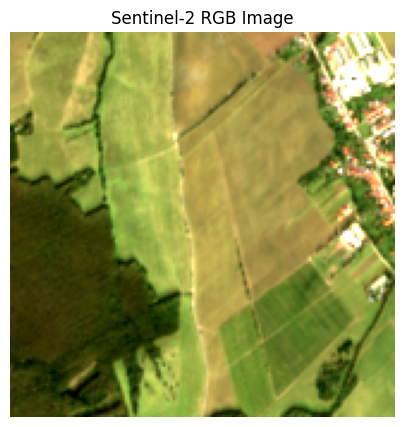

In [ ]:
with rasterio.open(base_path / "mean_bands_cube.tiff") as src:
    pixel_size_x = src.transform.a
    pixel_size_y = -src.transform.e
    print(f"Pixel Size: {pixel_size_x} x {pixel_size_y} units")

    r = src.read(4)  # Band 3
    g = src.read(3)  # Band 2
    b = src.read(2)  # Band 1

rgb = np.stack([r, g, b], axis=0)
rgb_img = np.transpose(rgb, (1, 2, 0))

# Normalize using percentiles
def normalize_percentile(img, lower=2, upper=98):
    p_low, p_high = np.percentile(img, (lower, upper))
    img_clipped = np.clip(img, p_low, p_high)
    return (img_clipped - p_low) / (p_high - p_low)

rgb_norm = normalize_percentile(rgb_img)

plt.figure(figsize=(5, 5))
plt.imshow(rgb_norm)
plt.title("Sentinel-2 RGB Image")
plt.axis("off")
plt.show()

## PCA & T-SNE model execution

### Exploration of the data and the model

When performing __PCA__, one of the key outputs is the __Explained Variance Ratio__. This metric tells us how much of the total variance in the original data is captured by each principal component. In other words, it helps us understand:

- How many components are needed to retain most of the information (variance) in the data.

- Which components are most informative, allowing us to reduce dimensionality effectively without losing essential structure.

- Whether dimensionality reduction introduces significant information loss.

This makes the explained variance ratio a crucial diagnostic tool in PCA-based workflows, especially when deciding how many components to retain for visualization or modeling.

In contrast, __Spectral Embedding__ is a nonlinear, probabilistic technique designed specifically for visualization in 2D or 3D. Its goal is not to preserve global variance, but rather:

- To preserve local structure (i.e., similar points in high-dimensional space remain close in the low-dimensional space).

- To separate dissimilar clusters for better visual interpretability.

Because of its nonlinear nature and its focus on local neighborhood preservation, there’s no concept of explained variance in Spectral Embedding. The axes in Spectral Embedding plots are arbitrary and not ordered by information content — unlike Spectral Embedding. Therefore, metrics like explained variance ratio are not meaningful or computable for Spectral Embedding. We also have a pre-trained Spectral Embedding model as a nonlinear, probabilistic dimensionality reduction technique, but we will not use it since it is too slow.

We start by downloading the pre-trained PCA-model (InconsistentVersionWarnings can be ignored):

*__Notice__: We also considered UMAP, t-SNE, and Locally Linear Embedding (LLE) as nonlinear dimensionality reduction techniques. However, we chose to continue with Spectral Embedding, as it offers a good balance between preserving local structure and computational efficiency for our dataset.*

In [12]:
# Step 1: Download the ZIP file from the URL
response = requests.get(models_url)
response.raise_for_status()  # make sure the download was successful

# Step 2: Read the ZIP file in memory
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Step 3: List files in the ZIP to find your pickle file
print("Files in the ZIP:", zip_file.namelist())

# Step 4: Open the pickle file inside the ZIP
with zip_file.open("dim_reduction_pca.pkl") as f:
    pca_model= pickle.load(f)


Files in the ZIP: ['dim_reduction_umap.pkl', 'dim_reduction_lle.pkl', 'dim_reduction_pca.pkl', 'dim_reduction_se.pkl', 'dim_reduction_tsne.pkl']


This visualization helps understand how many principal components are needed to capture most of the variance in the data. If the first few bars are tall and the rest are small, it means those components explain most of the variance, and dimensionality reduction can be effective.

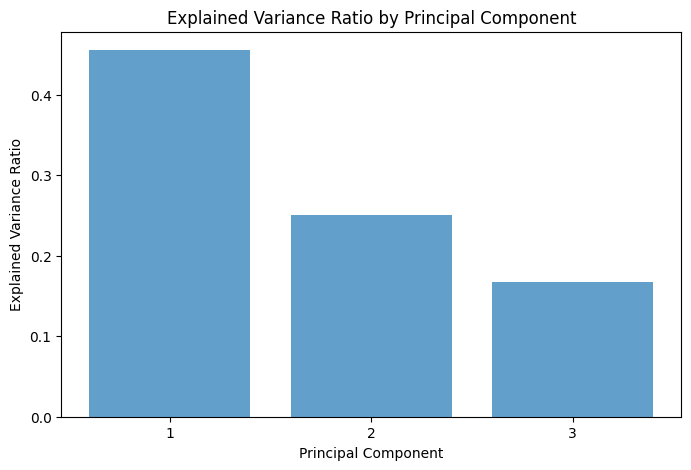

In [13]:
explained_variance_ratio = pca_model.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

This plot helps you decide how many principal components to keep in your analysis by showing the cumulative amount of variance explained. For example, if the curve reaches 90% explained variance at the 4th component, you might choose to keep only the first 4 components for dimensionality reduction.

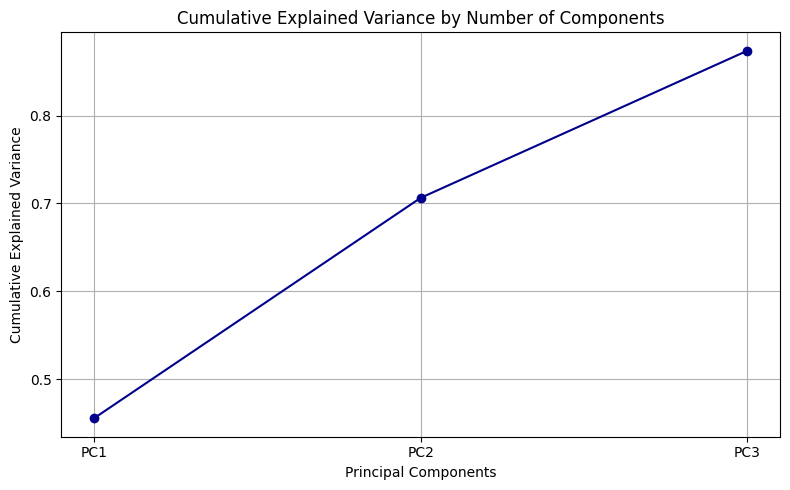

In [14]:
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create x-tick labels like "PC1", "PC2", ...
pc_labels = [f'PC{i}' for i in range(1, len(cumulative_variance) + 1)]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='darkblue')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.xticks(ticks=range(1, len(cumulative_variance) + 1), labels=pc_labels)
plt.grid(True)
plt.tight_layout()
plt.show()

This code helps identify which original spectral bands (features) are most influential in the PCA model by examining the loadings. It filters out bands with insignificant contributions and visually ranks bands by their maximum contribution to any principal component. This can guide feature selection, interpretation, or further analysis by focusing on the most important spectral bands.

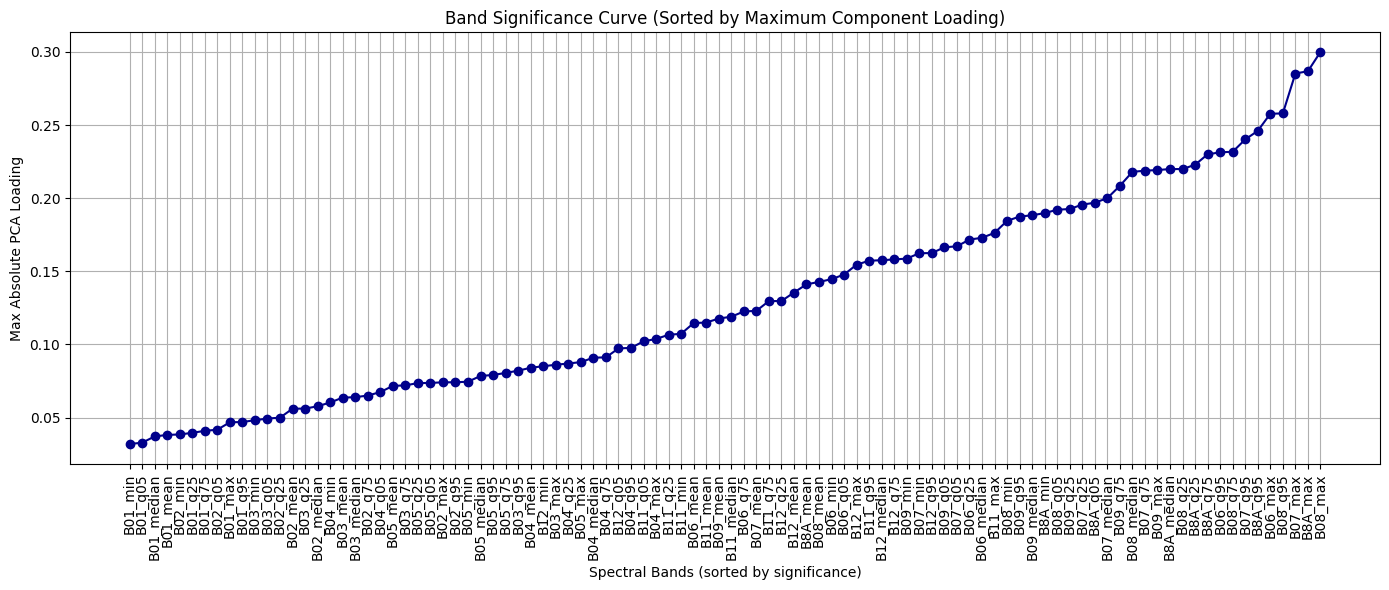

In [15]:
components = pca_model.components_  # shape: (n_components, n_bands)
original_band_names= sentinel_master_cube.metadata.band_names

threshold = 0.01 # define significance threshold 

# Find bands with at least one loading above threshold (in absolute value)
significant_bands_mask = np.any(np.abs(components) >= threshold, axis=0)

# Calculate aggregate importance per band (e.g., max absolute loading across PCs)
band_importance = np.max(np.abs(components), axis=0)  # or use np.sum(...) or np.mean(...)

# Only keep significant bands
band_importance_significant = band_importance[significant_bands_mask]
significant_band_names = np.array(original_band_names)[significant_bands_mask]

# Sort by importance
sorted_indices = np.argsort(band_importance_significant)
sorted_importance = band_importance_significant[sorted_indices]
sorted_band_names = significant_band_names[sorted_indices]

# Plot as a curve
plt.figure(figsize=(14, 6))
plt.plot(sorted_importance, marker='o', linestyle='-', color='darkblue')
plt.xticks(ticks=np.arange(len(sorted_band_names)), labels=sorted_band_names, rotation=90)
plt.title('Band Significance Curve (Sorted by Maximum Component Loading)')
plt.ylabel('Max Absolute PCA Loading')
plt.xlabel('Spectral Bands (sorted by significance)')
plt.grid(True)
plt.tight_layout()
plt.show()


This heatmap visually summarizes which spectral bands contribute strongly to which principal components and whether the contribution is positive or negative. By filtering for significant bands, the plot focuses on the most meaningful relationships in the PCA, helping you interpret how each component is formed by combinations of original bands.

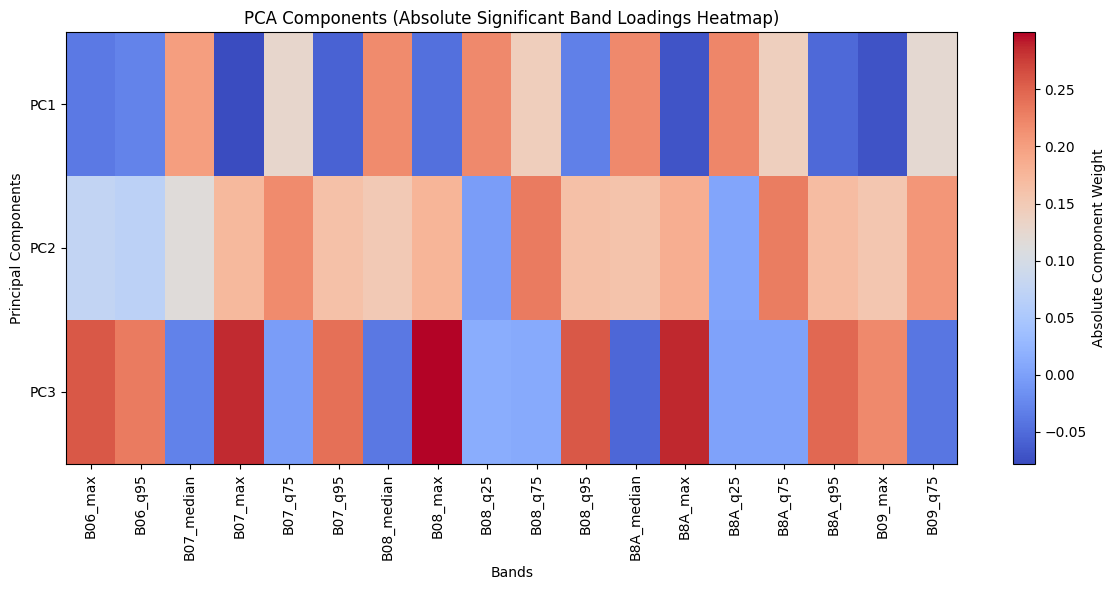

In [16]:
components = pca_model.components_  # shape: (n_components, n_bands)
original_band_names = sentinel_master_cube.metadata.band_names

threshold = 0.20  # define significance threshold

# Find bands with at least one loading above threshold (in absolute value)
significant_bands_mask = np.any(np.abs(components) >= threshold, axis=0)

# Filter components to keep only significant bands
components_filtered = components[:, significant_bands_mask]

# Get only significant band names for the x-axis labels
significant_band_names = [original_band_names[i] for i in np.where(significant_bands_mask)[0]]

plt.figure(figsize=(12, 6))
plt.imshow(components_filtered, aspect='auto', cmap='coolwarm')  # Changed to a sequential colormap for magnitude

plt.colorbar(label='Absolute Component Weight')

plt.xlabel('Bands')
plt.ylabel('Principal Components')
plt.title('PCA Components (Absolute Significant Band Loadings Heatmap)')
plt.yticks(ticks=np.arange(components_filtered.shape[0]), labels=[f'PC{i+1}' for i in range(components_filtered.shape[0])])

plt.xticks(ticks=np.arange(components_filtered.shape[1]), 
           labels=significant_band_names, 
           rotation=90)

plt.tight_layout()
plt.show()


##  PCA vs. Spectral Embedding

Both **PCA** and **Spectral Embedding** are dimensionality reduction techniques, but they differ fundamentally in their assumptions and goals.

### PCA (Principal Component Analysis)
- **Type**: Linear
- **Objective**: Find directions (principal components) that capture the **maximum variance** in the data.
- **Method**: Eigen-decomposition of the covariance matrix.
- **Captures**: **Global structure** in the data.
- **Output**: Linear combinations of original features.
- **Interpretability**: High (components are based on feature contributions).
- **Best for**: Linearly structured data, noise reduction, feature compression, preprocessing for regression or classification.

### Spectral Embedding (Laplacian Eigenmaps)
- **Type**: Non-linear (manifold learning)
- **Objective**: Preserve **local neighborhood relationships** in a lower-dimensional space.
- **Method**: Build a similarity graph, compute the graph Laplacian, and use its eigenvectors.
- **Captures**: **Local structure**, especially for data on curved or non-linear manifolds.
- **Output**: Coordinates based on graph topology (not directly tied to original features).
- **Interpretability**: Low to moderate (depends on graph structure).
- **Best for**: Cluster discovery, visualizing non-linear structures (e.g., Swiss roll), preprocessing for spectral clustering.

---

### Summary Table

| Feature                        | PCA                            | Spectral Embedding             |
|-------------------------------|---------------------------------|--------------------------------|
| Type                          | Linear                          | Non-linear                     |
| Preserves                     | Global variance                 | Local structure                |
| Sensitive to Non-linearity    | ❌                              | ✅                             |
| Uses Feature Covariance?      | ✅                              | ❌                             |
| Constructs Similarity Graph?  | ❌                              | ✅                             |
| Interpretability              | High                            | Low                            |
| Speed                         | Fast                            | Slower (due to graph)          |
| Use Case                      | Compression, modeling           | Clustering, visualization      |

Based on the previous curves we decide to only keep bands with a weight of at least 0.20. The underlying UDF selects those feautues based on our PCA model.

In [36]:
feature_selection_udf_obj = openeo.UDF.from_file("udf_feature_selection.py",
                                   context={"threshold": 0.20})
significant_bands_cube = sentinel_master_cube.apply(
    process=feature_selection_udf_obj,
)

In [ ]:
selection_job = significant_bands_cube.create_job(
    title="feature_selection_job", out_format="NetCDF", job_options=job_options
)
selection_job.start_and_wait()
selection_job.download_result("results/significant_bands.nc")

0:00:00 Job 'j-2507021120024c7383a0e0b0b747fd22': send 'start'
0:00:17 Job 'j-2507021120024c7383a0e0b0b747fd22': created (progress 0%)
0:00:22 Job 'j-2507021120024c7383a0e0b0b747fd22': created (progress 0%)
0:00:28 Job 'j-2507021120024c7383a0e0b0b747fd22': created (progress 0%)
0:00:36 Job 'j-2507021120024c7383a0e0b0b747fd22': created (progress 0%)
0:00:46 Job 'j-2507021120024c7383a0e0b0b747fd22': created (progress 0%)
0:00:58 Job 'j-2507021120024c7383a0e0b0b747fd22': created (progress 0%)
0:01:14 Job 'j-2507021120024c7383a0e0b0b747fd22': queued (progress 0%)
0:01:33 Job 'j-2507021120024c7383a0e0b0b747fd22': queued (progress 0%)
0:01:57 Job 'j-2507021120024c7383a0e0b0b747fd22': queued (progress 0%)
0:02:27 Job 'j-2507021120024c7383a0e0b0b747fd22': running (progress N/A)
0:03:05 Job 'j-2507021120024c7383a0e0b0b747fd22': running (progress N/A)
0:03:52 Job 'j-2507021120024c7383a0e0b0b747fd22': running (progress N/A)
0:04:50 Job 'j-2507021120024c7383a0e0b0b747fd22': running (progress N/A)


WindowsPath('results/significant_bands.nc')

Checkto how many of the bands are reduced and left

In [11]:
# Open the NetCDF file
ds = xr.open_dataset("results/significant_bands.nc")

# Extract band variables, excluding 'crs'
bands = [var for var in ds.data_vars if var != "crs"]

# Print total count
print(f"{len(bands)} bands left:\n")

# Print bands in a numbered list
for i, band in enumerate(bands, start=1):
    print(f"{i}. {band}")

18 bands left:

1. B06_max
2. B06_q95
3. B07_median
4. B07_max
5. B07_q75
6. B07_q95
7. B08_median
8. B08_max
9. B08_q25
10. B08_q75
11. B08_q95
12. B8A_median
13. B8A_max
14. B8A_q25
15. B8A_q75
16. B8A_q95
17. B09_max
18. B09_q75


### Dimensionality Reduction

Apply the Dimensionality Reduction UDF with PCA within a neighbourhood of 512x512 pixels.

In [88]:
pca_udf_obj = openeo.UDF.from_file("udf_dim_reduction.py",
                                   context={"model_type": "PCA"}
                                   )
components = significant_bands_cube.apply_neighborhood(
    process=pca_udf_obj,
    size=[
        {"dimension": "x", "value": 384, "unit": "px"},
        {"dimension": "y", "value": 384, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
)
pca_job = components.create_job(
    title="pca_job", out_format="NetCDF", job_options=job_options
)
pca_job.start_and_wait()
pca_job.download_result("results/pca_results.nc")

0:00:00 Job 'j-2507021753224cd7aa1a325fa314cdb9': send 'start'
0:00:13 Job 'j-2507021753224cd7aa1a325fa314cdb9': created (progress 0%)
0:00:18 Job 'j-2507021753224cd7aa1a325fa314cdb9': created (progress 0%)
0:00:24 Job 'j-2507021753224cd7aa1a325fa314cdb9': created (progress 0%)
0:00:32 Job 'j-2507021753224cd7aa1a325fa314cdb9': created (progress 0%)
0:00:42 Job 'j-2507021753224cd7aa1a325fa314cdb9': created (progress 0%)
0:00:54 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progress N/A)
0:01:10 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progress N/A)
0:01:29 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progress N/A)
0:01:53 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progress N/A)
0:02:23 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progress N/A)
0:03:00 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progress N/A)
0:03:47 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progress N/A)
0:04:45 Job 'j-2507021753224cd7aa1a325fa314cdb9': running (progres

WindowsPath('results/pca_results.nc')

Apply the Dimensionality Reduction UDF with Spectral Embedding model within a neighbourhood of 512x512 pixels.
Be carefull with increasing neighbourhood size since Spectral Embedding is Memory-intensive.

In [89]:
lle_udf_obj = openeo.UDF.from_file("udf_dim_reduction.py",
                                   context={"model_type": "SE"}
                                    )
components = significant_bands_cube.apply_neighborhood(
    process=lle_udf_obj,
    size=[
        {"dimension": "x", "value": 384, "unit": "px"},
        {"dimension": "y", "value": 384, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
)
lle_job = components.create_job(
    title="se_job", out_format="NetCDF", job_options=job_options
)
lle_job.start_and_wait()
lle_job.download_result("results/se_results.nc")

0:00:00 Job 'j-2507021759104e8b9b1018413c4f1b77': send 'start'
0:00:12 Job 'j-2507021759104e8b9b1018413c4f1b77': created (progress 0%)
0:00:17 Job 'j-2507021759104e8b9b1018413c4f1b77': created (progress 0%)
0:00:24 Job 'j-2507021759104e8b9b1018413c4f1b77': created (progress 0%)
0:00:32 Job 'j-2507021759104e8b9b1018413c4f1b77': created (progress 0%)
0:00:41 Job 'j-2507021759104e8b9b1018413c4f1b77': created (progress 0%)
0:00:54 Job 'j-2507021759104e8b9b1018413c4f1b77': created (progress 0%)
0:01:09 Job 'j-2507021759104e8b9b1018413c4f1b77': running (progress N/A)
0:01:29 Job 'j-2507021759104e8b9b1018413c4f1b77': running (progress N/A)
0:01:53 Job 'j-2507021759104e8b9b1018413c4f1b77': running (progress N/A)
0:02:23 Job 'j-2507021759104e8b9b1018413c4f1b77': running (progress N/A)
0:03:01 Job 'j-2507021759104e8b9b1018413c4f1b77': running (progress N/A)
0:03:48 Job 'j-2507021759104e8b9b1018413c4f1b77': running (progress N/A)
0:04:46 Job 'j-2507021759104e8b9b1018413c4f1b77': running (progress

WindowsPath('results/se_results.nc')

## Visualise Output

When performing dimensionality reduction on spatial data, the output components represent key underlying patterns or features extracted from the original dataset. Visualizing these components side-by-side helps reveal how different spatial structures contribute to the overall variability. By examining subtle variations in each component, we can better understand dominant spatial trends, detect anomalies, or identify meaningful features that may not be obvious in the raw data. Effective visualization with appropriate color scaling ensures these differences are clear and interpretable, aiding in model validation, feature selection, and communication of results.

These new bands with the most important information, are not only easier easier to visualize and analyze, imaging plotting 141 bands, they could also be used in Machine-learning models as input bands.

In [90]:
pca_job_data = xr.open_dataset(base_path / "pca_results.nc")
se_job_data = xr.open_dataset(base_path / "se_results.nc")

In [91]:
def concat_features_to_bands_dim(ds: xr.DataArray):
    # List band variables
    band_vars = [var for var in ds.data_vars if ds[var].dtype.kind in 'fc' and set(ds[var].dims) == {'y', 'x'}]

    cube = xr.concat([ds[var] for var in band_vars], dim="bands")
    cube = cube.assign_coords(bands=band_vars)  # name the bands
    return cube.rename('__xarray_dataarray_variable__')

def plot_components(data_array: xr.DataArray, model_name: str):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    print(type(data_array))

    for i, ax in enumerate(axes):
        comp_data = np.abs(data_array.isel(bands=i))  # take absolute value here
        
        # Use percentiles to plot as vmin & vmax to highlight differences
        vmin = comp_data.quantile(0.05).item()
        vmax = comp_data.quantile(0.95).item()

        im = ax.imshow(comp_data, vmin=vmin, vmax=vmax)
        ax.set_title(f'COMP{i+1}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Add a general title
    fig.suptitle(f"{model_name} Components", fontsize=16)

    plt.tight_layout()
    plt.show()

<class 'xarray.core.dataarray.DataArray'>


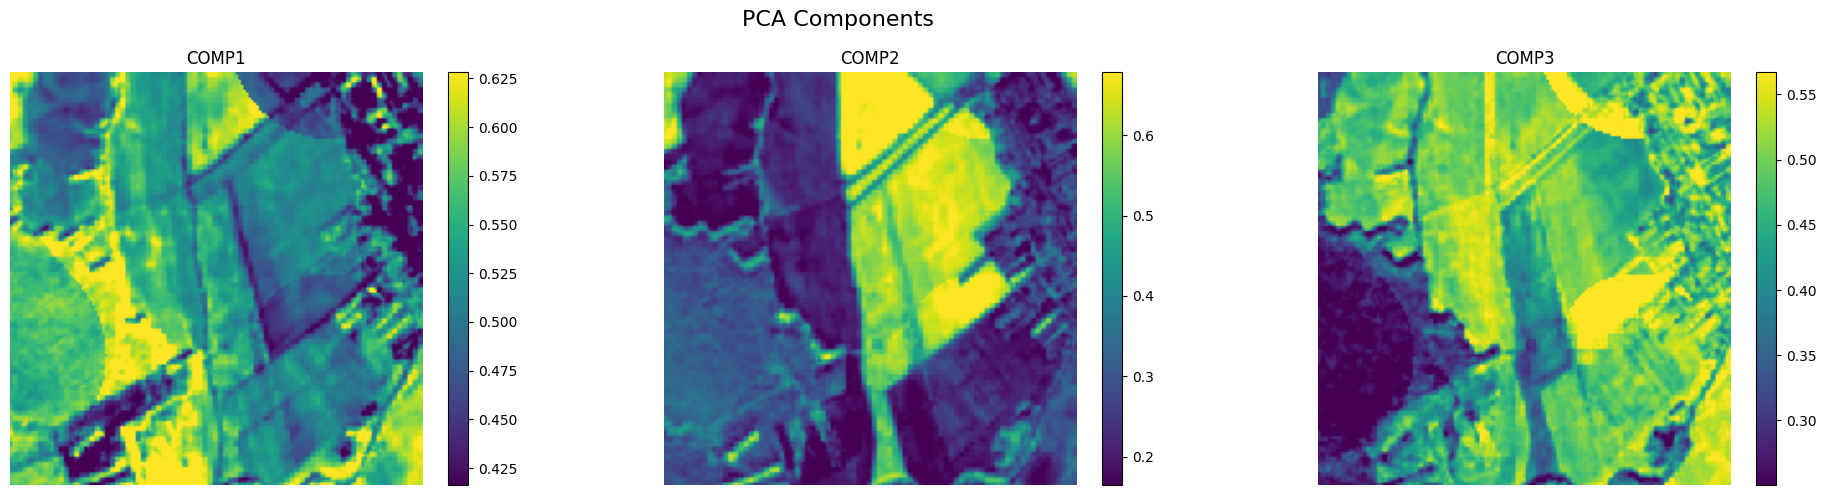

<class 'xarray.core.dataarray.DataArray'>


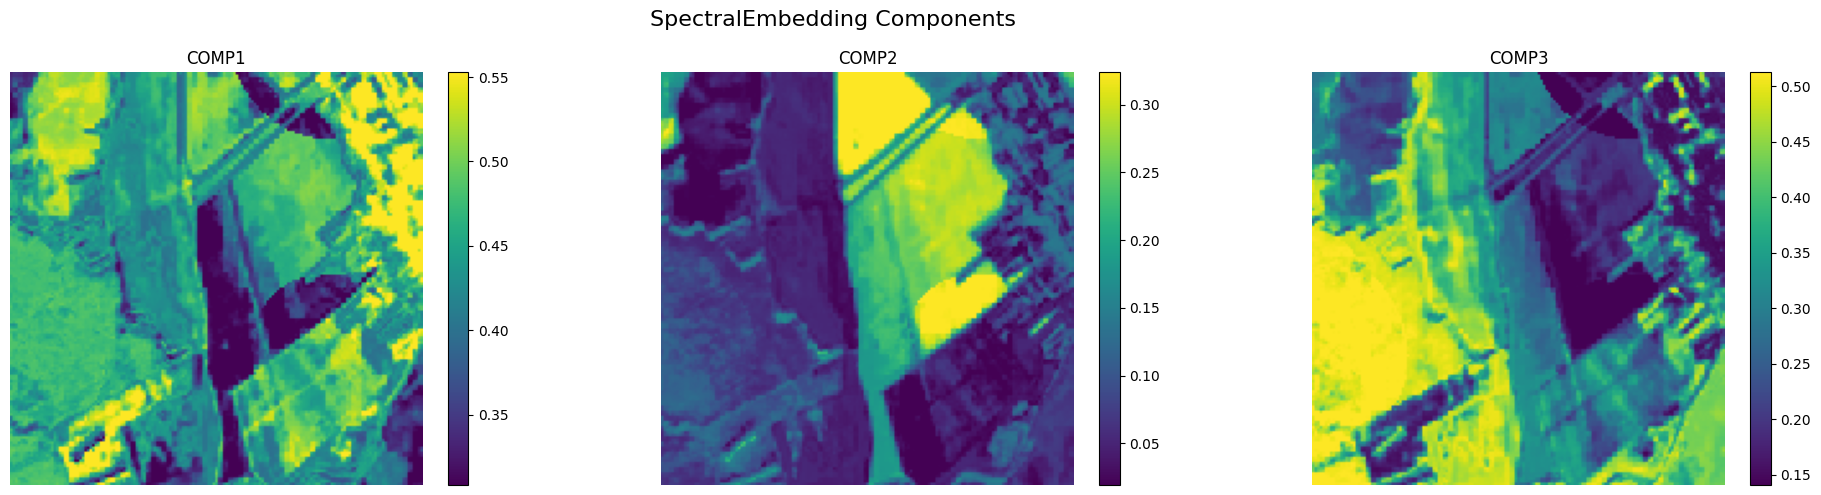

In [92]:
pca_job_data_array= concat_features_to_bands_dim(pca_job_data)
se_job_data_array= concat_features_to_bands_dim(se_job_data)

plot_components(pca_job_data_array, "PCA")
plot_components(se_job_data_array, "SpectralEmbedding")